In [1]:
from pathlib import Path
from collections import Counter
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
BASE = Path('..')
DATA = BASE / 'HDFS_v1' / 'preprocessed'
OUT = BASE / 'out'
OUT.mkdir(exist_ok=True, parents=True)
FIG = BASE / 'figures'
FIG.mkdir(exist_ok=True, parents=True)

In [3]:
plt.rcParams['figure.figsize'] = (9.0, 5.0)
plt.rcParams['axes.grid'] = True

# 1 Загрузка данных

## 1.1 Чтение csv

In [4]:
labels = pd.read_csv(DATA / 'anomaly_label.csv')
occurrence = pd.read_csv(DATA / 'Event_occurrence_matrix.csv')
traces = pd.read_csv(DATA / 'Event_traces.csv')
templates = pd.read_csv(DATA / 'HDFS.log_templates.csv')

In [5]:
print('Labels shape', labels.shape)
print('Occurrence shape', occurrence.shape)
print('Traces shape', traces.shape)
print('Templates shape', templates.shape)

Labels shape (575061, 2)
Occurrence shape (575061, 32)
Traces shape (575061, 6)
Templates shape (29, 2)


## 1.2 Ознакомление с датасетами

In [6]:
print(labels.info())
print(labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 entries, 0 to 575060
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   BlockId  575061 non-null  object
 1   Label    575061 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB
None
                    BlockId    Label
0  blk_-1608999687919862906   Normal
1   blk_7503483334202473044   Normal
2  blk_-3544583377289625738  Anomaly
3  blk_-9073992586687739851   Normal
4   blk_7854771516489510256   Normal


In [7]:
print(occurrence.info())
print(occurrence.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 entries, 0 to 575060
Data columns (total 32 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   BlockId  575061 non-null  object 
 1   Label    575061 non-null  object 
 2   Type     16838 non-null   float64
 3   E1       575061 non-null  int64  
 4   E2       575061 non-null  int64  
 5   E3       575061 non-null  int64  
 6   E4       575061 non-null  int64  
 7   E5       575061 non-null  int64  
 8   E6       575061 non-null  int64  
 9   E7       575061 non-null  int64  
 10  E8       575061 non-null  int64  
 11  E9       575061 non-null  int64  
 12  E10      575061 non-null  int64  
 13  E11      575061 non-null  int64  
 14  E12      575061 non-null  int64  
 15  E13      575061 non-null  int64  
 16  E14      575061 non-null  int64  
 17  E15      575061 non-null  int64  
 18  E16      575061 non-null  int64  
 19  E17      575061 non-null  int64  
 20  E18      575061 non-null  

In [8]:
print(traces.info())
print(traces.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 entries, 0 to 575060
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   BlockId       575061 non-null  object 
 1   Label         575061 non-null  object 
 2   Type          16838 non-null   float64
 3   Features      575061 non-null  object 
 4   TimeInterval  575061 non-null  object 
 5   Latency       575061 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 26.3+ MB
None
                    BlockId    Label  Type  \
0  blk_-1608999687919862906  Success   NaN   
1   blk_7503483334202473044  Success   NaN   
2  blk_-3544583377289625738     Fail  21.0   
3  blk_-9073992586687739851  Success   NaN   
4   blk_7854771516489510256  Success   NaN   

                                            Features  \
0  [E5,E22,E5,E5,E11,E11,E9,E9,E11,E9,E26,E26,E26...   
1  [E5,E5,E22,E5,E11,E9,E11,E9,E11,E9,E26,E26,E26...   
2  [E5,E22,E5,E5,E11,E9,E

In [9]:
print(templates.info())
print(templates.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   EventId        29 non-null     object
 1   EventTemplate  29 non-null     object
dtypes: object(2)
memory usage: 596.0+ bytes
None
  EventId                           EventTemplate
0      E1  [*]Adding an already existing block[*]
1      E2        [*]Verification succeeded for[*]
2      E3                 [*]Served block[*]to[*]
3      E4  [*]Got exception while serving[*]to[*]
4      E5    [*]Receiving block[*]src:[*]dest:[*]


## 1.2 Проверка пропусков

In [10]:
for name, df in [('labels',labels),('traces',traces),('occurrence',occurrence)]:
    print('=====', name, '=====')
    print(df.isna().sum().sort_values(ascending=False).head(8))
    print()

===== labels =====
BlockId    0
Label      0
dtype: int64

===== traces =====
Type            558223
BlockId              0
Label                0
Features             0
TimeInterval         0
Latency              0
dtype: int64

===== occurrence =====
Type       558223
BlockId         0
E15             0
E28             0
E27             0
E26             0
E25             0
E24             0
dtype: int64



В датасетах traces и occerrence 558223 пропусков по признаку Type.

Судя по нескольким наблюдениям из этих датасетов, Type заполняется только для наблюдений имеющих значение Fail по признаку Label. Проверим для всех ли наблюдений это справедливо.

In [11]:
table = pd.crosstab(traces['Label'], traces['Type'].isna(),
                    rownames=['Label'], colnames=['Type_is_NaN'], margins=False)
print(table)

Type_is_NaN  False   True 
Label                     
Fail         16838       0
Success          0  558223


## 1.4 Проверка дубликатов по id

In [12]:
labels_duplicate = labels.shape[0] - labels['BlockId'].nunique()
occurrence_duplicate = occurrence.shape[0] - occurrence['BlockId'].nunique()
traces_duplicate = traces.shape[0] - traces['BlockId'].nunique()
templates_duplicate = templates.shape[0] - templates['EventId'].nunique()

for dup_count in (labels_duplicate, occurrence_duplicate, traces_duplicate, templates_duplicate):
    if dup_count != 0:
        print(f'{dup_count} duplicates found')
else:
    print('No duplicates found')

No duplicates found


## 1.5 Выводы

1. Загружено 4 файла из HDFS_v1/preprocessed/:
- HDFS.log_templates.csv (29 x 2)  - справочник шаблонов событий.
    - EventId - идентификатор события (E1...E29).
    - EventTemplate - текстовый шаблон лога (с плейсхолдерами [*]).
- anomaly_label.csv (575061 x 2) - разметка на уровне трейса (блока).
    - BlockId - идентификатор трейса.
    - Label - Normal / Anomaly.
- Event_traces.csv (575061 x 6) - последовательности событий по каждому BlockId.
    - BlockId - идентификатор трейса.
    - Label - Success / Fail (Fail эквивалентен Anomaly).
    - Type - код типа отказа (заполнен только для Fail, для Success - NaN).
    - Features - упорядоченный список EventId в трейсе ('[E5,E22,…]').
    - TimeInterval - список интервалов между событиями, той же длины, что len(Features)-1.
    - Latency - суммарная длительность трейса (мс) - равна сумме TimeInterval.
- Event_occurrence_matrix.csv (575061 x 32) - счётчики событий в трейсе.
    - BlockId, Label, Type - аналогично.
    - E1...E29 - количество вхождений каждого события в данном трейсе.
2. Целостность:
- Пропущенные значения по признаку Type обоснованы - это тип Fail (для Success - Nan).
- Дубликаты BlockId/EventId в таблицах отсутствуют.


# 2 Анализ распределений

## 2.1 Баланс классов

In [13]:
anomaly_encoding_dict = {'Normal': 0, 'Anomaly': 1}
labels['isAnomaly'] = labels['Label'].map(anomaly_encoding_dict)

anomaly_percentage = round(float(labels['isAnomaly'].mean()) * 100, 2)
print(f'Anomaly percentage: {anomaly_percentage} %')

Anomaly percentage: 2.93 %


## 2.2 Длина последовательности событий по классам

In [14]:
def calc_seq_len(s: str) -> int:
    return len(s.split(','))

traces['sequence_len'] = traces['Features'].map(calc_seq_len)
print(traces['sequence_len'].describe())

count    575061.000000
mean         19.433815
std           5.177735
min           2.000000
25%          19.000000
50%          19.000000
75%          20.000000
max         298.000000
Name: sequence_len, dtype: float64


In [15]:
table = (traces[['BlockId', 'sequence_len', 'Latency']].merge(
    labels[['BlockId', 'isAnomaly']], on='BlockId'))

print('=== Sequence length by class ===')
print(table.groupby('isAnomaly')['sequence_len'].describe())

=== Sequence length by class ===
              count       mean        std   min   25%   50%   75%    max
isAnomaly                                                               
0          558223.0  19.503637   4.775583  13.0  19.0  19.0  20.0  298.0
1           16838.0  17.119017  12.409644   2.0   4.0  20.0  26.0  284.0


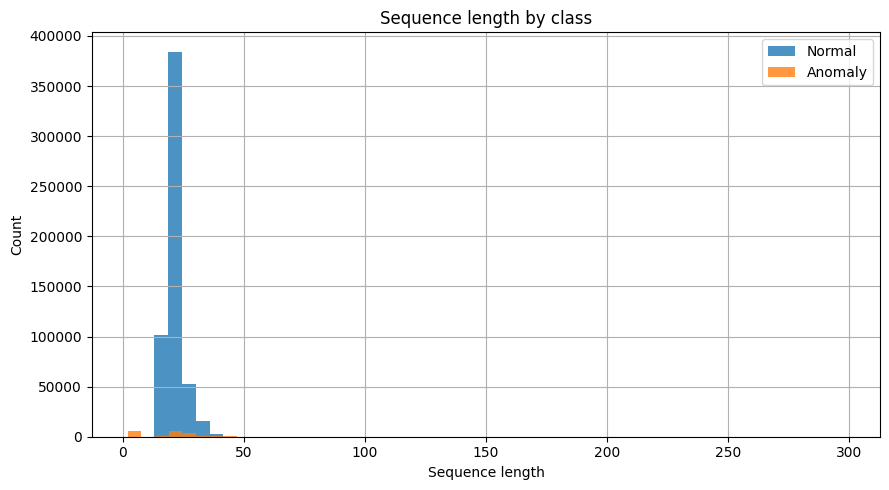

In [16]:
plt.figure()
table[table.isAnomaly  == 0]['sequence_len'].hist(bins=50, alpha=0.8, label='Normal')
table[table.isAnomaly  == 1]['sequence_len'].hist(bins=50, alpha=0.8, label='Anomaly')
plt.title('Sequence length by class')
plt.xlabel('Sequence length')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig(FIG / 'sequence_length_by_class_hist.png', dpi=300)


Судя по перцентилям в норме длина последовательности имеет резкий пик на 19 событий, а у аномалий встречаются как короткие (2-4) так и длинные (>20).


## 2.3 Задержка по классам (boxplot)

In [17]:
print('=== Latency (ms) by class ===')
print(table.groupby('isAnomaly')['Latency'].describe())

=== Latency (ms) by class ===
              count          mean           std  min     25%     50%      75%  \
isAnomaly                                                                       
0          558223.0  16870.912341  17865.694194  0.0  1241.0  7303.0  33732.0   
1           16838.0  14089.464960  18376.636894  0.0     3.0  4920.5  31717.5   

               max  
isAnomaly           
0          54025.0  
1          53924.0  


<Figure size 900x500 with 0 Axes>

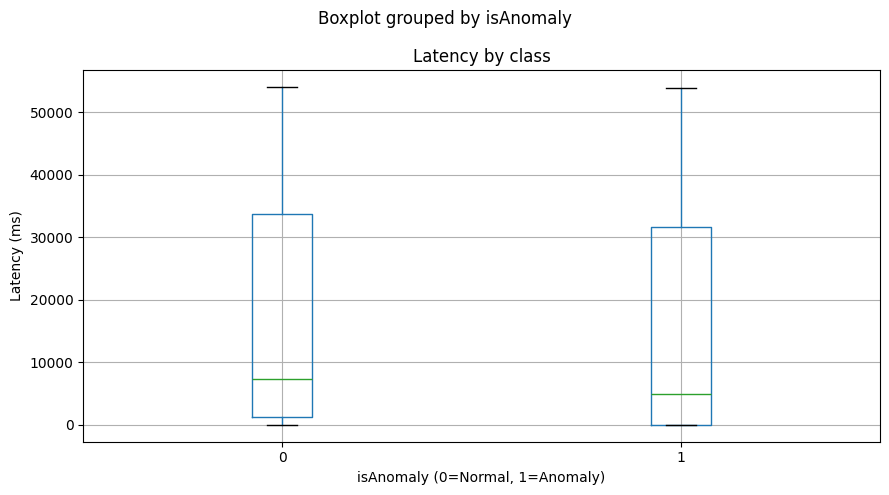

In [18]:
plt.figure()
table.boxplot(column='Latency', by='isAnomaly')
plt.title('Latency by class')
plt.xlabel('isAnomaly (0=Normal, 1=Anomaly)')
plt.ylabel('Latency (ms)')
plt.tight_layout()
plt.savefig(FIG / 'latency_by_class_boxplot.png', dpi=300)

По признаку Latency распределения сильно перекрываются.

## 2.4 Взаимосвязь Latency и sequence_len (scatter plot)

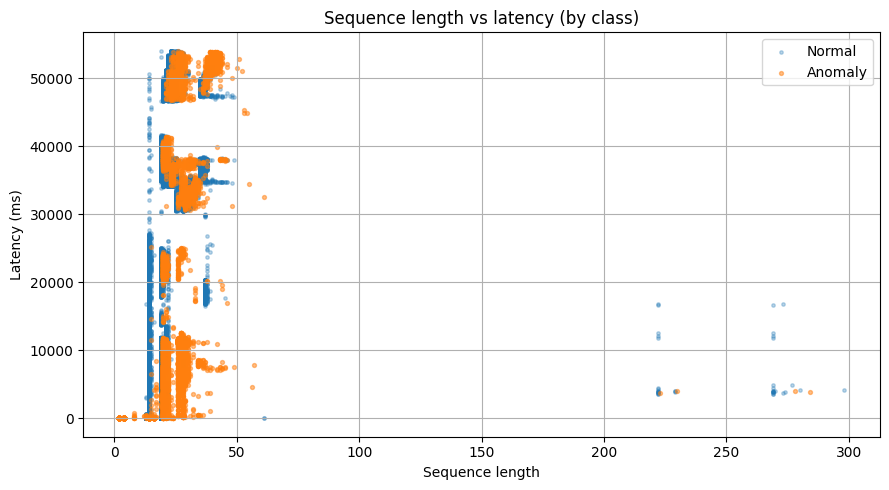

In [19]:
plt.figure()

norm = table[table['isAnomaly'] == 0]
plt.scatter(
    norm['sequence_len'], norm['Latency'],
    s=6, alpha=0.3, label='Normal'
)

anom = table[table['isAnomaly'] == 1]
plt.scatter(
    anom['sequence_len'], anom['Latency'],
    s=8, alpha=0.5, label='Anomaly'
)

plt.title('Sequence length vs latency (by class)')
plt.xlabel('Sequence length')
plt.ylabel('Latency (ms)')
plt.legend()
plt.tight_layout()
plt.savefig(FIG / 'sequence_length_vs_latency_by_class_scatter.png', dpi=300)

По картинке видно сильное перекрытие классов. На длительность влияет не только длина последовательности, но и внутренняя динамика (TimeInterval).

## 2.5 TimeInterval (csv + boxplots)

### Проверка согласованности TimeInterval и Features

In [20]:
def parse_ti(s: str) -> list[float]:
    arr = s[1:-1].split(', ')
    return [float(x) for x in arr]

ti_len = traces['TimeInterval'].map(lambda s: len(parse_ti(s)))
print('TimeInterval len mismatch event sequence len count:', (ti_len != traces['sequence_len'] - 1).sum())

TimeInterval len mismatch event sequence len count: 0


Признак TimeInterval согласован с Features (для всех событий в последовательности указано время).

### Статистики по TimeInterval для каждого трейса

In [21]:
def ti_stats(s: str):
    a = np.array(parse_ti(s), dtype=float)
    return pd.Series({
        'ti_sum': a.sum(),
        'ti_mean': a.mean(),
        'ti_max': a.max(),
        'ti_std': a.std(ddof=0),
        'ti_zeros': (a==0).mean()
    })

ti_series = traces['TimeInterval'].apply(ti_stats)
ti_series = pd.concat([traces[['BlockId']], ti_series], axis=1).merge(labels[['BlockId', 'isAnomaly']], on='BlockId')

ti_lat_df = ti_series.merge(traces[['BlockId', 'Latency']], on='BlockId')

ti_lat_df[['BlockId', 'ti_sum', 'ti_mean', 'ti_max', 'ti_std', 'ti_zeros']].to_csv(
    OUT / 'timeinterval_stats_per_trace.csv', index=False)
ti_lat_df

,BlockId,ti_sum,ti_mean,ti_max,ti_std,ti_zeros,isAnomaly,Latency
0,blk_-1608999687919862906,3802.0,14.186567,3703.0,225.770180,0.880597,0,3802
1,blk_7503483334202473044,3802.0,181.047619,3044.0,649.220153,0.666667,0,3802
2,blk_-3544583377289625738,3797.0,17.103604,3713.0,248.627028,0.896396,1,3797
3,blk_-9073992586687739851,50448.0,2402.285714,49727.0,10582.327038,0.619048,0,50448
4,blk_7854771516489510256,50583.0,1367.108108,46034.0,7465.767935,0.405405,0,50583
...,...,...,...,...,...,...,...,...
575056,blk_1019720114020043203,128.0,7.111111,49.0,14.995884,0.666667,0,128
575057,blk_-2683116845478050414,120.0,6.666667,80.0,18.439089,0.722222,0,120
575058,blk_5595059397348477632,111.0,6.166667,52.0,14.111658,0.777778,0,111
575059,blk_1513937873877967730,106.0,5.888889,51.0,13.735149,0.722222,0,106


### Проверка согласованности TimeInterval и Latency

In [22]:
print('TimeInterval sum mismatch Latency count:', (ti_lat_df['ti_sum'] != ti_lat_df['Latency']).sum())

TimeInterval sum mismatch Latency count: 0


Признак TimeInterval согласован с Latency (сумма межсобытийных интервалов равна задержке)

### Описательная статистика признаков 'ti_sum', 'ti_mean', 'ti_max', 'ti_std', 'ti_zeros' по классам

In [23]:
ti_desc_df = ti_series.groupby('isAnomaly')[['ti_sum', 'ti_mean', 'ti_max', 'ti_std', 'ti_zeros']].describe().round(3)
ti_desc_df.to_csv(OUT / 'timeinterval_desc_group_by_label.csv')
ti_desc_df

ti_sum                                                      \
              count       mean        std  min     25%     50%      75%   
isAnomaly                                                                 
0          558223.0  16870.912  17865.694  0.0  1241.0  7303.0  33732.0   
1           16838.0  14089.465  18376.637  0.0     3.0  4920.5  31717.5   

                     ti_mean           ...    ti_std             ti_zeros  \
               max     count     mean  ...       75%        max     count   
isAnomaly                              ...                                  
0          54025.0  558223.0  800.719  ...  5087.296  13463.853  558223.0   
1          53924.0   16838.0  551.827  ...  3252.814  10080.472   16838.0   

                                                          
            mean    std    min    25%    50%    75%  max  
isAnomaly                                                 
0          0.655  0.121  0.216  0.583  0.667  0.722  1.0  
1          0.620  0.213  0.000  0.486  0.632  0.684  1.0  

[2 rows x 40 columns]

### Средний промежуток между событиями в трейсе

<Figure size 900x500 with 0 Axes>

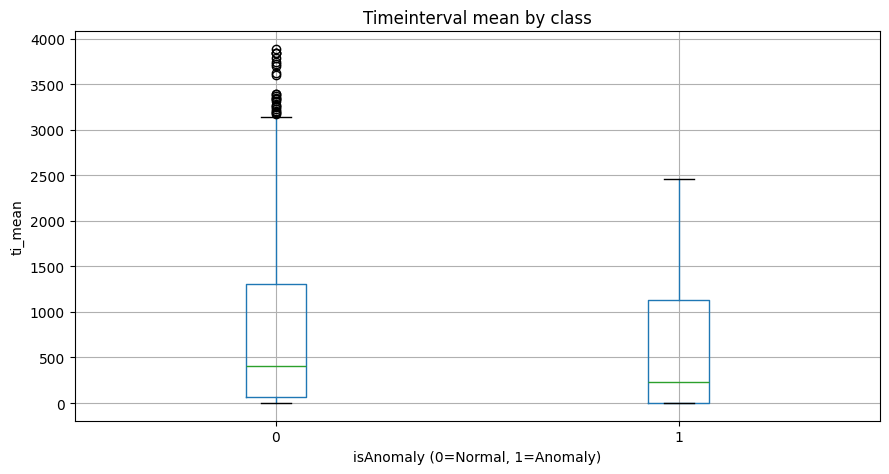

In [24]:
plt.figure()
ti_series.boxplot(column='ti_mean', by='isAnomaly')
plt.title('Timeinterval mean by class')
plt.suptitle('')
plt.xlabel('isAnomaly (0=Normal, 1=Anomaly)')
plt.ylabel('ti_mean')
plt.tight_layout()
plt.savefig(FIG / 'timeinterval_mean_by_class_boxplot.png', dpi=300)

У аномалий медиана ниже (трейсы либо короче, либо события идут плотнее).

### Максимальная пауза внутри трейса

<Figure size 900x500 with 0 Axes>

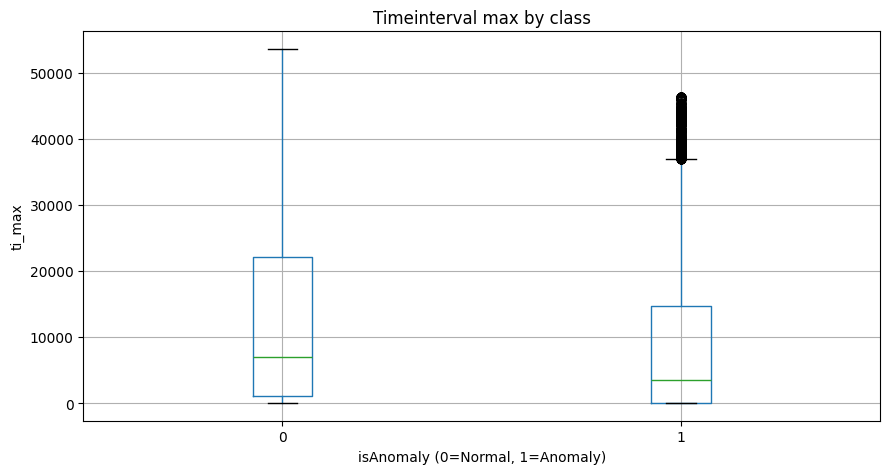

In [25]:
plt.figure()
ti_series.boxplot(column='ti_max', by='isAnomaly')
plt.title('Timeinterval max by class')
plt.suptitle('')
plt.xlabel('isAnomaly (0=Normal, 1=Anomaly)')
plt.ylabel('ti_max')
plt.tight_layout()
plt.savefig(FIG / 'timeinterval_max_by_class_boxplot.png', dpi=300)

В норме максимумы выше (длинные паузы встречаются и при нормальной работе).

### Разброс интервалов

<Figure size 900x500 with 0 Axes>

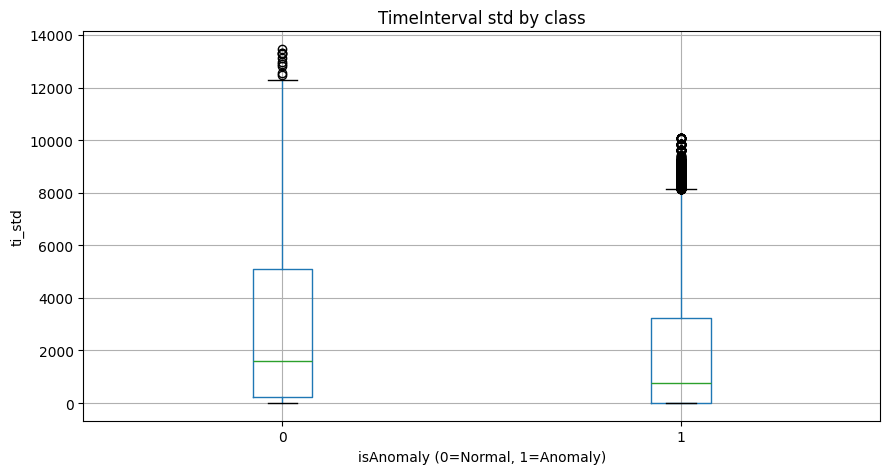

In [26]:
plt.figure()
ti_series.boxplot(column='ti_std', by='isAnomaly')
plt.title('TimeInterval std by class')
plt.suptitle('')
plt.xlabel('isAnomaly (0=Normal, 1=Anomaly)')
plt.ylabel('ti_std')
plt.tight_layout()
plt.savefig(FIG / 'timeinterval_std_by_class_boxplot.png', dpi=300)

В норме разброс сильнее (у аномалий ритм чуть более стабильный)

### Доля нулевых промежутков

<Figure size 900x500 with 0 Axes>

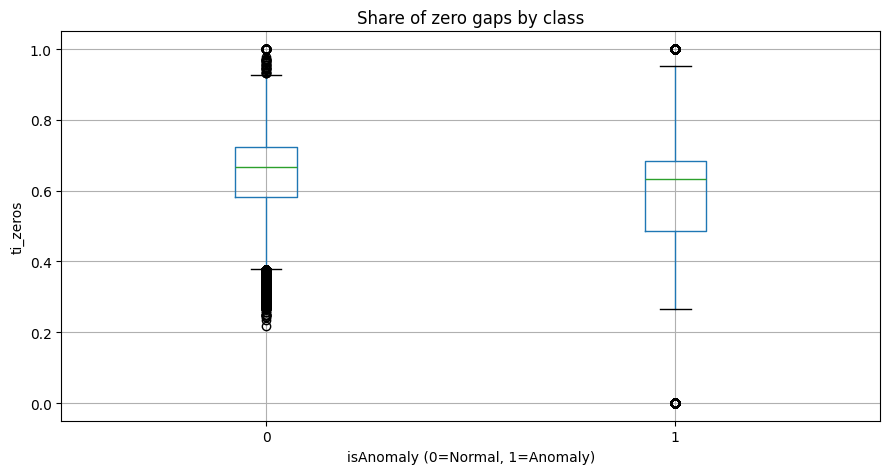

In [27]:
plt.figure()
ti_series.boxplot(column='ti_zeros', by='isAnomaly')
plt.title('Share of zero gaps by class')
plt.suptitle('')
plt.xlabel('isAnomaly (0=Normal, 1=Anomaly)')
plt.ylabel('ti_zeros')
plt.tight_layout()
plt.savefig(FIG / 'timeinterval_zeros_by_class_boxplot.png', dpi=300)

У аномалий медиана чуть ниже, распределения сильно перекрываются.

## 2.6 Наборы событий (csv)

### События встречающиеся только в аномалиях/норме и в обоих типах одновременно

In [28]:
event_id_columns = [c for c in occurrence.columns if c.startswith('E')]
occ_and_lab = occurrence.merge(labels[['BlockId', 'isAnomaly']], on='BlockId')

present_norm = (occ_and_lab[occ_and_lab.isAnomaly == 0][event_id_columns] > 0).sum()
present_anom = (occ_and_lab[occ_and_lab.isAnomaly == 1][event_id_columns] > 0).sum()

events_norm_set = set(present_norm[present_norm > 0].index)
events_anom_set = set(present_anom[present_anom > 0].index)

events_only_norm = sorted(events_norm_set - events_anom_set)
events_only_anom = sorted(events_anom_set - events_norm_set)
events_norm_and_anom = sorted(events_norm_set & events_anom_set)

print(f'Events total: {len(event_id_columns)}')
print(f'Events norm only: {len(events_only_norm)}')
print(f'Events anom only: {len(events_only_anom)}')
print(f'Both: {len(events_norm_and_anom)}')

Events total: 29
Events norm only: 0
Events anom only: 12
Both: 17


In [29]:
templates_map_dict = templates.set_index('EventId')['EventTemplate'].to_dict()

events_only_anomaly_df = pd.DataFrame({
    'EventId': events_only_anom,
    'EventTemplate': [templates_map_dict.get(event_id) for event_id in events_only_anom]
})
events_norm_and_anom_df = pd.DataFrame({
    'EventId': events_norm_and_anom,
    'EventTemplate': [templates_map_dict.get(event_id) for event_id in events_norm_and_anom]
})

events_only_anomaly_df.to_csv(OUT / 'events_only_anomaly.csv', index=False)

In [30]:
print('Only anomaly events:')
print(events_only_anomaly_df)

Only anomaly events:
   EventId                                      EventTemplate
0       E1             [*]Adding an already existing block[*]
1      E10                  [*]PacketResponder[*]Exception[*]
2      E12         [*]:Exception writing block[*]to mirror[*]
3      E13             [*]Receiving empty packet for block[*]
4      E14          [*]Exception in receiveBlock for block[*]
5      E15  [*]Changing block file offset of block[*]from[...
6      E17               [*]:Failed to transfer[*]to[*]got[*]
7      E19                                 [*]Reopen Block[*]
8      E24  [*]BLOCK* Removing block[*]from neededReplicat...
9      E29    [*]PendingReplicationMonitor timed out block[*]
10      E7              [*]writeBlock[*]received exception[*]
11      E8    [*]PacketResponder[*]for block[*]Interrupted[*]


В основном сообщения об ошибках/исключениях.

## 2.7 Самые частые события в аномалиях/норме

Строим топы по долям событий внутри классов (т.к. дисбаланс).

In [31]:
p_normal = occ_and_lab[occ_and_lab.isAnomaly == 0][event_id_columns].sum()
p_anomaly = occ_and_lab[occ_and_lab.isAnomaly == 1][event_id_columns].sum()

p_normal = p_normal / p_normal.sum()
p_anomaly = p_anomaly / p_anomaly.sum()

normal_top = p_normal.nlargest(10)
anomaly_top = p_anomaly.nlargest(10)

In [32]:
events_normal_top10_df = pd.DataFrame({
    'EventId': normal_top.index,
    'FrequencyInNormal': normal_top.values,
    'EventTemplate': [templates_map_dict.get(event_id) for event_id in normal_top.index]
})

events_anomaly_top10_df = pd.DataFrame({
    'EventId': anomaly_top.index,
    'FrequencyInAnomalies': anomaly_top.values,
    'EventTemplate': [templates_map_dict.get(event_id) for event_id in anomaly_top.index]
})

events_normal_top10_df = events_normal_top10_df.head(10)
events_normal_top10_df.to_csv(OUT / 'events_normal_top10.csv', index=False)

events_anomaly_top10_df = events_anomaly_top10_df.head(10)
events_anomaly_top10_df.to_csv(OUT / 'events_anomaly_top10.csv', index=False)

In [33]:
print('\nTop-10 events by share within normal', events_normal_top10_df, sep='\n')


Top-10 events by share within normal
  EventId  FrequencyInNormal  \
0     E26           0.154260   
1      E5           0.154058   
2      E9           0.153817   
3     E11           0.153817   
4     E21           0.125519   
5     E23           0.125306   
6     E22           0.051272   
7      E3           0.038291   
8      E4           0.031959   
9      E2           0.010738   

                                       EventTemplate  
0  [*]BLOCK* NameSystem[*]addStoredBlock: blockMa...  
1               [*]Receiving block[*]src:[*]dest:[*]  
2              [*]Received block[*]of size[*]from[*]  
3    [*]PacketResponder[*]for block[*]terminating[*]  
4                        [*]Deleting block[*]file[*]  
5  [*]BLOCK* NameSystem[*]delete:[*]is added to i...  
6           [*]BLOCK* NameSystem[*]allocateBlock:[*]  
7                            [*]Served block[*]to[*]  
8             [*]Got exception while serving[*]to[*]  
9                   [*]Verification succeeded for[*]  


In [34]:
print('\nTop-10 events by share within anomaly', events_anomaly_top10_df, sep='\n')


Top-10 events by share within anomaly
  EventId  FrequencyInAnomalies  \
0      E5              0.159393   
1     E26              0.139657   
2     E21              0.123063   
3     E11              0.111049   
4     E23              0.110748   
5      E9              0.110477   
6     E22              0.058415   
7      E3              0.041082   
8      E4              0.028652   
9     E20              0.018467   

                                       EventTemplate  
0               [*]Receiving block[*]src:[*]dest:[*]  
1  [*]BLOCK* NameSystem[*]addStoredBlock: blockMa...  
2                        [*]Deleting block[*]file[*]  
3    [*]PacketResponder[*]for block[*]terminating[*]  
4  [*]BLOCK* NameSystem[*]delete:[*]is added to i...  
5              [*]Received block[*]of size[*]from[*]  
6           [*]BLOCK* NameSystem[*]allocateBlock:[*]  
7                            [*]Served block[*]to[*]  
8             [*]Got exception while serving[*]to[*]  
9  [*]Unexpected error tr

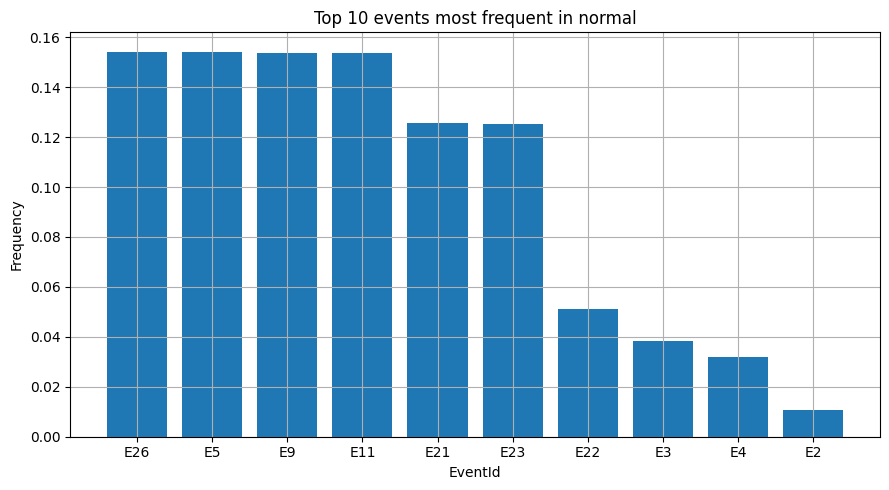

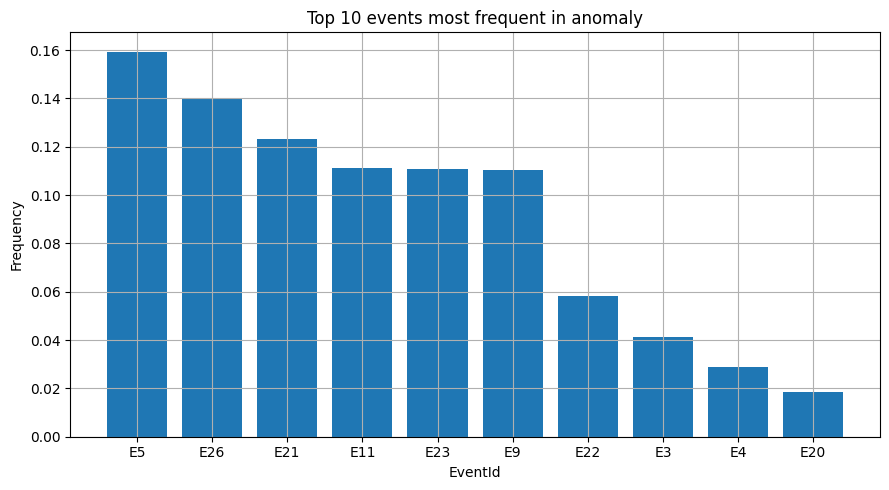

In [35]:
plt.figure()
plt.bar(events_normal_top10_df['EventId'].astype(str), events_normal_top10_df['FrequencyInNormal'])
plt.title('Top 10 events most frequent in normal')
plt.xlabel('EventId')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(FIG / 'events_normal_top10_bar.png', dpi=300)

plt.figure()
plt.bar(events_anomaly_top10_df['EventId'].astype(str), events_anomaly_top10_df['FrequencyInAnomalies'])
plt.title('Top 10 events most frequent in anomaly')
plt.xlabel('EventId')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(FIG / 'events_anomaly_top10_bar.png', dpi=300)

- И в норме, и в аномалиях доминируют E5, E26, E11, E21, E9, E23 (операции приема/передачи/фиксации/удаления блоков).
- Различия в долях есть, но умеренные - в аномалиях немного выше доля E5, E21, E22, чем в норме. В норме чуть выше E26, E9, E11, E23.
- В топ 10 аномалий попадает E20 (ошибка при удалении блока), которой нет в топ 10 нормы.

Вывод: по маргинальным частотам распределения сильно перекрываются, нужно смотреть совместные паттерны.

## 2.8 События более характерные для аномалий

Строим топ по разности долей, ищем события склоняющиеся к аномалиям (что чаще в аномалиях, чем в норме).

In [36]:
skew_to_anomaly = (p_anomaly - p_normal).sort_values(ascending=False)
skew_to_anomaly = skew_to_anomaly[skew_to_anomaly > 0].sort_values(ascending=False).head(10)

events_skew_to_anomaly_top10_df = pd.DataFrame({
    'EventId': skew_to_anomaly.index,
    'FrequencyInAnomalies': skew_to_anomaly.values,
    'EventTemplate': [templates_map_dict.get(event_id) for event_id in skew_to_anomaly.index]
})

events_skew_to_anomaly_top10_df = events_skew_to_anomaly_top10_df.head(10)
events_skew_to_anomaly_top10_df.to_csv(OUT / 'events_skew_to_anomaly_top10.csv', index=False)

print('Top 10 events most skew to anomaly')
print(events_skew_to_anomaly_top10_df)

Top 10 events most skew to anomaly
  EventId  FrequencyInAnomalies  \
0     E20              0.018446   
1      E6              0.015302   
2     E18              0.015236   
3     E25              0.015236   
4     E16              0.015014   
5      E7              0.011851   
6     E22              0.007142   
7      E5              0.005335   
8     E13              0.005079   
9     E28              0.004426   

                                       EventTemplate  
0  [*]Unexpected error trying to delete block[*]B...  
1      [*]Received block[*]src:[*]dest:[*]of size[*]  
2       [*]Starting thread to transfer block[*]to[*]  
3               [*]BLOCK* ask[*]to replicate[*]to[*]  
4                      [*]:Transmitted block[*]to[*]  
5              [*]writeBlock[*]received exception[*]  
6           [*]BLOCK* NameSystem[*]allocateBlock:[*]  
7               [*]Receiving block[*]src:[*]dest:[*]  
8             [*]Receiving empty packet for block[*]  
9  [*]BLOCK* NameSystem[*]add

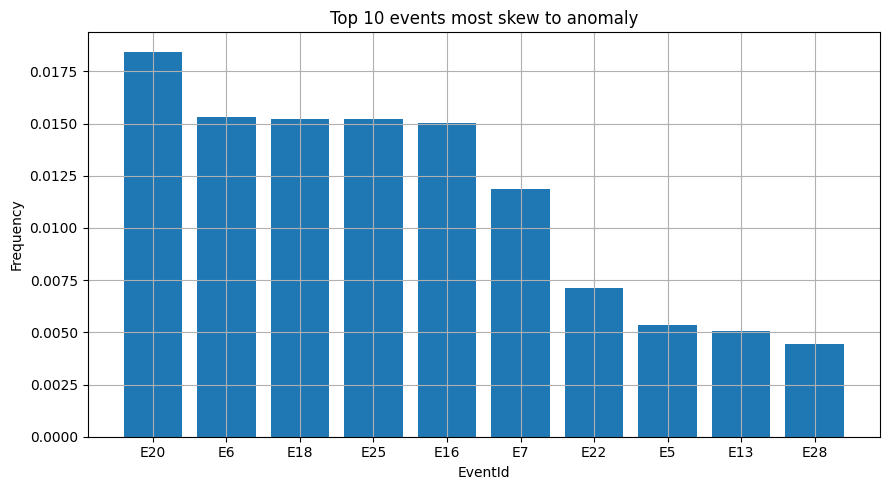

In [37]:
plt.figure()
plt.bar(events_skew_to_anomaly_top10_df['EventId'].astype(str), events_skew_to_anomaly_top10_df['FrequencyInAnomalies'])
plt.title('Top 10 events most skew to anomaly')
plt.xlabel('EventId')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(FIG / 'events_skew_to_anomaly_top10_bar.png', dpi=300)

- Топ-индикаторы E20, E6, E18, E25, E16, E7, E22, E5, E13, E28.
- E20, E7, E13 - явные ошибки/исключения (E7, E13 встречаются только в аномалиях).
- E6, E18, E25, E16, E22, E28, E5 - операции передачи/репликации/выделения блоков, но их относительная доля выше в аномалиях (признак перегрузок/повторов/репликационных взрывов).

Вывод: наличие E20/E7/E13 и других шаблонов, встречающихся только в аномалиях резко повышает риск, для остальных важен контекст в последователоьности.

## 2.9 Переходы (пары последовательных событий)

### Топ 30 переходов (csv)

Смотрим самые частые пары последовательных событий

In [38]:
# "[E5,E22,E5,...]" -> ["E5","E22","E5",...]
def parse_features(s: str) -> list[str]:
    if pd.isna(s): return []
    s = s.strip()
    if s.startswith('[') and s.endswith(']'):
        s = s[1:-1].strip()
    if not s: return []
    return [event_id.strip() for event_id in s.split(',') if event_id.strip()]

def count_transitions(df: pd.DataFrame) -> Counter:
    counts = Counter()
    for seq in df['Features'].map(parse_features):
        for a, b in zip(seq, seq[1:]):
            counts[(a, b)] += 1
    return counts

transitions_counter = count_transitions(traces)
print('Transitions count:', len(transitions_counter))

Transitions count: 280


In [39]:
event_transitions_top30_df = pd.DataFrame([{
    'From': key[0],
    'To': key[1],
    'Count': value
} for key, value in transitions_counter.most_common(30)])

event_transitions_top30_df.to_csv(OUT / 'event_transitions_top30.csv', index=False)

print('Top 10 most frequent transitions:')
print(event_transitions_top30_df.head(10))

Top 10 most frequent transitions:
  From   To    Count
0  E11   E9  1683645
1  E26  E26  1020811
2   E9  E11  1008973
3  E23  E23   931159
4  E21  E21   925635
5   E5   E5   907739
6   E9  E26   575874
7  E23  E21   464075
8   E5  E22   427443
9  E22   E5   378225


В топе типичные операционные циклы: E11->E9, E9->E11, а так же повторы E26->E26, E23->E23, E21->E21, E5->E5.

### Топ 30 переходов типичных для каждого класса (csv)

Смотрим самые частые (по log_ratio) пары последовательных событий по долям для каждого класса

In [40]:
table = (traces[['BlockId', 'Features']].merge(
    labels[['BlockId', 'isAnomaly']], on='BlockId'))

transitions_normal_counter = count_transitions(table[table.isAnomaly == 0])
transitions_anomaly_counter = count_transitions(table[table.isAnomaly == 1])

all_keys = set(list(transitions_normal_counter.keys()) + list(transitions_anomaly_counter.keys()))
rows = []
sum_norm = sum(transitions_normal_counter.values()) or 1
sum_anom = sum(transitions_anomaly_counter.values()) or 1

for k in all_keys:
    cN = transitions_normal_counter.get(k,0)
    cA = transitions_anomaly_counter.get(k,0)
    cT = cN + cA
    pN = cN / sum_norm
    pA = cA / sum_anom

    ratio = math.log((pA+1e-12)/(pN+1e-12))
    rows.append((k[0], k[1], cN, cA, cT, pN, pA, ratio))

event_transitions_df = pd.DataFrame(rows, columns=["prev","next","cnt_norm","cnt_anom","cnt_total","p_norm","p_anom","log_ratio"])

df_filtered = event_transitions_df[event_transitions_df['cnt_total'] >= 100]
event_transitions_skew_anomaly_top30_df = df_filtered.sort_values('log_ratio', ascending=False).head(30)
event_transitions_skew_normal_top30_df = df_filtered.sort_values('log_ratio').head(30)

event_transitions_skew_anomaly_top30_df.to_csv(OUT / 'event_transitions_skew_anomaly_top30.csv', index=False)
event_transitions_skew_normal_top30_df.to_csv(OUT / 'event_transitions_skew_normal_top30.csv', index=False)

In [41]:
print("Top 10 event transitions skew to normal:")
print(event_transitions_skew_normal_top30_df[['prev','next','cnt_anom','cnt_norm','p_anom','p_norm','log_ratio']].head(10))

Top 10 event transitions skew to normal:
    prev next  cnt_anom  cnt_norm    p_anom    p_norm  log_ratio
252   E3  E21         2       217  0.000007  0.000021  -1.047662
112  E23   E3         2       180  0.000007  0.000017  -0.860722
72    E9   E4       399     29980  0.001470  0.002902  -0.680236
159  E26   E2       384     28728  0.001415  0.002781  -0.675897
111  E26  E23      3849    267133  0.014181  0.025862  -0.600845
127  E22  E11      2841    184713  0.010467  0.017883  -0.535559
40   E11   E2         9       583  0.000033  0.000056  -0.531875
171  E26   E3       446     28134  0.001643  0.002724  -0.505327
197  E22  E26        41      2523  0.000151  0.000244  -0.480544
44    E9  E26     10012    565862  0.036889  0.054783  -0.395478


In [42]:
print("Top 10 event transitions skew to anomalies:")
print(event_transitions_skew_anomaly_top30_df[['prev','next','cnt_anom','cnt_norm','p_anom','p_norm','log_ratio']].head(10))

Top 10 event transitions skew to anomalies:
    prev next  cnt_anom  cnt_norm    p_anom  p_norm  log_ratio
215   E5   E7      1993         0  0.007343     0.0  22.717024
45   E22   E7      1264         0  0.004657     0.0  22.261664
8    E13  E11      1194         0  0.004399     0.0  22.204692
135   E9  E13       781         0  0.002878     0.0  21.780203
96    E4  E25       345         0  0.001271     0.0  20.963172
274  E27  E23       276         0  0.001017     0.0  20.740029
172   E5  E13       272         0  0.001002     0.0  20.725430
158  E13  E13       168         0  0.000619     0.0  20.243592
11   E22  E13       163         0  0.000601     0.0  20.213378
81   E14   E7       141         0  0.000520     0.0  20.068388


- log_ratio > 0 -> переход диспропорционально чаще в аномалиях, < 0 - чаще в норме.
- Среди топа склонных к норме - контекст финализация/учет. Массово встречаются в норме и значительно реже в аномалиях.
- Среди топа склонных к аномалиям переходов все пары имеют cnt_norm = 0. Эти связки сотни раз происходят в аномалиях и ни разу в норме. Типичный паттерн сбоя - связки вида exception/empty -> packet/allocate.

Вывод: нормальные логи характеризуются устойчивыми сервисными цепочками (E26->E23, E9->E26, E22->E11 и т.д), а аномалии - резкими переходами к ошибкам сразу после приема/выделения блоков.

### Матрица переходов (heatmap)

Смотрим насколько типичен для события (prev) каждый его исход (next) и как это меняется в аномалиях. Строим матрицы условных вероятностей P(next|prev) отдельно для нормы и аномалий. Считаем счетчики переходов, нормируем построчно, по всем представленным исходам (next) для каждого события (prev).

In [43]:
event_norm_counter = Counter()
for seq in table[table.isAnomaly == 0]['Features'].map(parse_features):
    event_norm_counter.update(seq)

events_norm_list = [e for e, _ in event_norm_counter.most_common()]
idx = {e: i for i, e in enumerate(events_norm_list)}

In [44]:
def count_transitions(df : pd.DataFrame):
    matrix = np.zeros((len(events_norm_list), len(events_norm_list)), dtype=float)
    row_counts = np.zeros(len(events_norm_list), dtype=float)
    for seq in df['Features'].map(parse_features):
        for a, b in zip(seq, seq[1:]):
            if a in idx and b in idx:
                ia, ib = idx[a], idx[b]
                matrix[ia, ib] += 1.0
                row_counts[ia] += 1.0
    return matrix, row_counts

matrix_norm, rc_norm = count_transitions(table[table.isAnomaly == 0])
matrix_anom, rc_anom = count_transitions(table[table.isAnomaly == 1])

P_norm = (matrix_norm.T / (rc_norm + 1e-12)).T
P_anom = (matrix_anom.T / (rc_anom + 1e-12)).T
Delta = P_anom - P_norm

pd.DataFrame(P_norm, index=events_norm_list, columns=events_norm_list).to_csv(OUT / 'P_norm.csv')
pd.DataFrame(P_anom, index=events_norm_list, columns=events_norm_list).to_csv(OUT / 'P_anom.csv')
pd.DataFrame(Delta,  index=events_norm_list, columns=events_norm_list).to_csv(OUT / 'P_delta.csv')

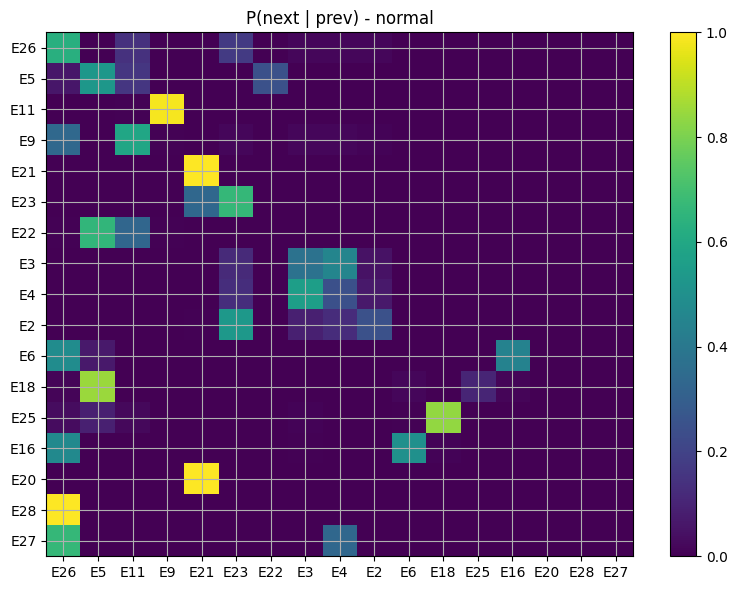

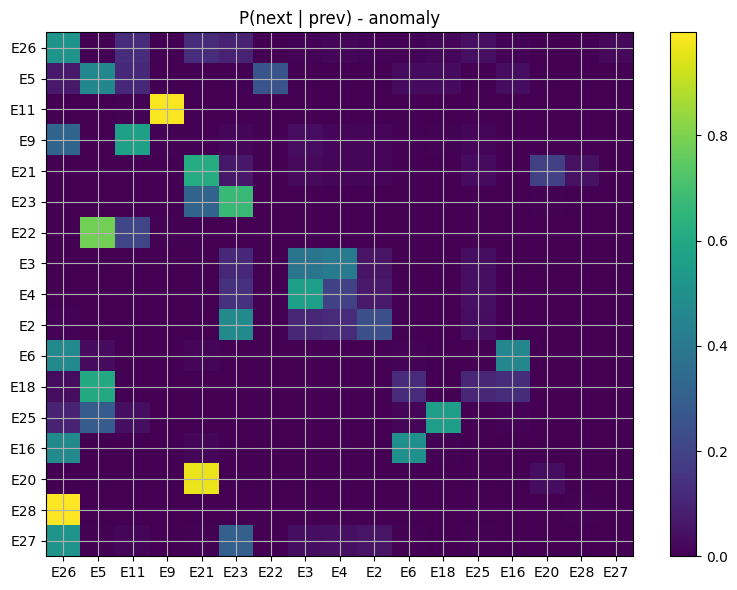

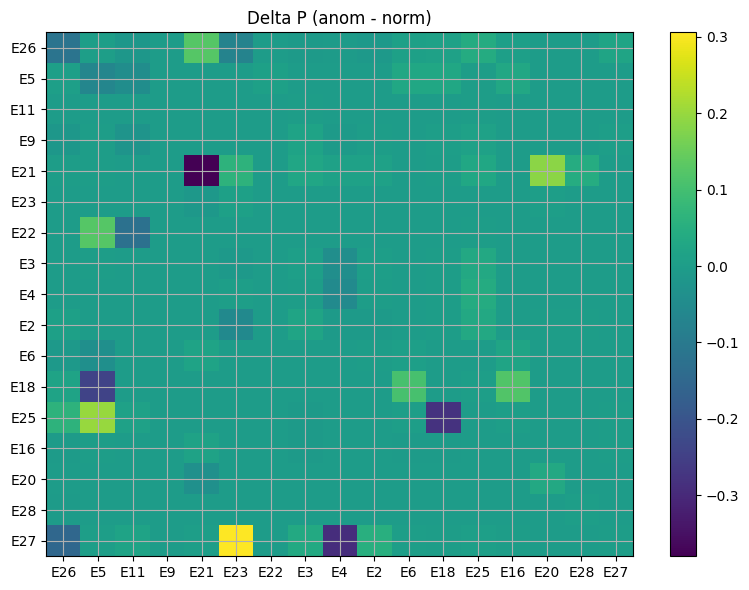

In [45]:
def plot_heatmap(matrix, title, file_name):
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(events_norm_list)), events_norm_list)
    plt.yticks(range(len(events_norm_list)), events_norm_list)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(FIG / file_name, dpi=300)

plot_heatmap(P_norm, "P(next | prev) - normal", "transitions_norm_heatmap.png")
plot_heatmap(P_anom, "P(next | prev) - anomaly", "transitions_anomaly_heatmap.png")
plot_heatmap(Delta, "Delta P (anom - norm)", "transitions_delta_heatmap.png")

Строка - событие prev (что было до), столбец - событие next (что наступило).
Тёплая клетка = для данного prev этот next встречается часто (типичный исход).
Ходная клетка = для данного prev этот next случается редко.

P_delta - показывает отличие аномального поведения от нормального (теплые клетки - переходы чаще аномальные, чем нормальные).


- Есть много общих переходов и для аномалий и для норм (E11->E9, E9->E11 и повторы E21->E21, E23->E23, E26->E26 и др.).
- В аномалиях резко чаще становятся E27->E23, E25->E5, E21->E20.
- В норме чаще чем в аномалиях E21->E21, E27->E4, E25->E18, E18->E5, E22->E11, E27->E26, E26->E26.

## 2.10 Выводы

1. Добавлены признаки для удобства анализа:
- isAnomaly (в датасет labels) - бинарный код (0/1).
- sequence_len (в датасет traces) — длина последовательности (len(Features)).
2. Глобальные распределения:
- Доля аномалий по anomaly_label ≈ 2.93% (класс сильно несбалансирован).
- sequence_len - у нормы резкий пик на 19 событий; у аномалий наблюдается ранний обрыв (2 - 4 события) и затяжные последовательности (> 20 событий).
- Latency - распределения нормы и аномалий сильно перекрываются; задержка слабо связана с длиной последовательности.
3. TimeInterval
- Согласовано с Latency (sum(TI)=Latency) для всех строк.
- Посчитаны агрегаты для TimeInterval каждого трейса 'ti_sum', 'ti_mean', 'ti_max', 'ti_std', 'ti_zeros', сохранено в 'timeinterval_stats_per_trace.csv'.
- Посчитаны статистики по этим признакам для каждой категории (Normal/Anomaly), сохранено в 'timeinterval_desc_group_by_label.csv'.
- У аномалий медианы ti_mean/ti_max ниже (в среднем трейс короче) но распределения перекрываются, ti_zeros отличается умеренно.
4. События и шаблоны:
- Из 29 шаблонов 17 встречаются и в норме и в аномалиях, 12 - встречаются только в аномалиях (в основном сообщения об ошибках/исключениях). Сохранено 'events_only_anomaly.csv'.
- По маргинальным частотам распределения сильно перекрываются. И в норме, и в аномалиях доминируют E5, E26, E11, E21, E9, E23 (операции приема/передачи/фиксации/удаления блоков). Важны не только одиночные события, но и контекст.
- События имеющие наибольшую долю по встречаемости в аномалиях, чем в норме: E20, E6, E18, E25, E16, E7, E22, E5, E13, E28 (из них E20, E7, E13 - явные ошибки/исключения). Можно использовать как бинарные индикаторы. Сохранены 'events_normal_top10.csv', 'events_anomaly_top10.csv'.
5. Последовательности пар событий (переходов)
- Найден 30 самых частых переходов среди всех: E11->E9, E9->E11, и повторы E26->E26 и тд. Сохранено в 'event_transitions_top30.csv'.
- Найдены 30 самых частых (по log_ratio) пар последовательных событий по долям для каждого класса (преобладание перехода в аномалиях). Нормальные логи характеризуются устойчивыми сервисными цепочками (E26->E23, E9->E26, E22->E11 и т.д), а аномалии - резкими переходами к ошибкам сразу после приема/выделения блоков. Сохранено в 'event_transitions_skew_anomaly_top30.csv' и 'event_transitions_skew_normal_top30.csv'.
- Построена матрица переходов (тепловая карта) по условной вероятности P(next|prev) раздельно для normal и anomaly. Можно использовать для марковского скоринга.
 - Теплые клетки - насколько типичен данный переход, холодные - нетипичен. На тепловой карте delta показаны исходы типичные для аномалий, при этом не типичные для нормы.
- В норме устойчивые переходы: E11<->E9, E21->E21 и др. Для аномалий резко возрастают переходы: E27->E23, E25->E5, E21->E20 и др.

# 3 Итоги EDA

1. Использован набор HDFS_v1 из Loghub. В рамках EDA рассмотрены предобработанные файлы HDFS_v1/preprocessed/. Данные качественные и согласованные. В дальнейшем планируется добавить этап шаблонизации сырого лога (Drain/Spell).
2. Рассмотренные файлы:
- HDFS.log_templates.csv - справочник шаблонов: EventId -> EventTemplate.
- Event_traces.csv - трейс на BlockId: упорядоченные Features (последовательность EventId), TimeInterval (задержки между соседними событиями из Features), Latency (суммарная длительность задержек из TimeInterval).
- Event_occurrence_matrix.csv - по каждому трейсу счётчики E1...E29.
- anomaly_label.csv - разметка Normal/Anomaly. Добавлены isAnomaly и sequence_len.
3. Исходя из проведенного EDA в качестве бейзлайна можно использовать:
- Табличный ML: счетчики событий E1...E29 из 'Event_occurrence_matrix.csv', длину последовательности sequence_len, суммарную задержку Latency, статистики задержек между событиями в последовательностях ti_mean/max/std/zeros, наличие событий only_anomaly и подозрительных переходов из P_delta, как индикаторы.
- Марковский скоринг: штрафуем трейс за каждый нетипичный переход (∑ -log P_norm(next|prev)).
4. Сохранены:
- figures/: histograms, boxplots, scatter plots, heatmaps.
- out/: event_transitions_skew_anomaly_top30.csv, event_transitions_skew_normal_top30.csv, event_transitions_top30.csv, events_anomaly_top10.csv, events_norm_top10.csv, events_only_anomaly.csv, P_anom.csv, P_delta.csv, P_norm.csv, timeinterval_desc_group_by_label.csv, timeinterval_stats_per_trace.csv.